In [1]:
3# Import Necessary Libiraries
import os
import numpy as np
import shutil
import glob
import random
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
train_dir = 'drive/My Drive/PaymentReceipt/dataset/train'
test_dir = 'drive/My Drive/PaymentReceipt/dataset/test'
val_dir = 'drive/My Drive/PaymentReceipt/dataset/val'

### Data Understanding

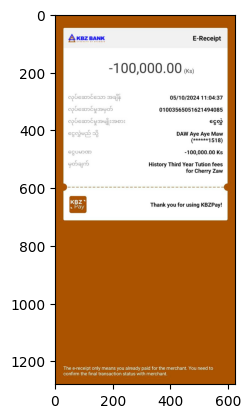

In [7]:
import cv2
import matplotlib.pyplot as plt

files = glob.glob(os.path.join(train_dir,'KPay') + '/*')[10]
image = cv2.imread(files)
plt.imshow(image)

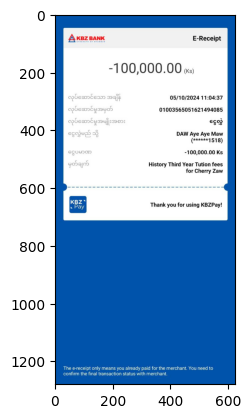

In [8]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)

### Data Preprocessing

In [ ]:
'''data_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
      transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])'''

data_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

'''data_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Random crop and resize to 224x224
    transforms.RandomHorizontalFlip(),   # Randomly flip images
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),               # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])
'''

# Dataset for training and evaluation
train_dataset = datasets.ImageFolder(root=train_dir, transform=data_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=data_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=data_transform)

# batch size
mini_batch_size = 16

# Load Data
train_loader = DataLoader(train_dataset, batch_size=mini_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=mini_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=mini_batch_size, shuffle=False)

class_names = ('AYAPay', 'CBPay', 'KPay', 'Other', 'WavePay')

### Modeling

In [ ]:
import torch
from torchsummary import summary
import torch.nn as nn
from torchvision import models

# Load pre-trained VGG16 with batch normalization
model_vgg16_bn = models.vgg16_bn(pretrained=True)

# Freeze all layers
for param in model_vgg16_bn.parameters():
    param.requires_grad = False

# Modify the classifier layer to match the number of classes
model_vgg16_bn.classifier[6] = nn.Linear(4096, len(class_names))

# Unfreeze the classifier layer for fine-tuning
for param in model_vgg16_bn.classifier.parameters():
    param.requires_grad = True

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_vgg16_bn.to(device)  # Move the model to the specified device (GPU/CPU)

# Print the model summary (input size: 3 channels, 224x224 image)
summary(model_vgg16_bn, (3, 224, 224), device=device.type)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:07<00:00, 74.2MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def check_gpu():

  use_gpu = torch.cuda.is_available()
  unit = "cpu"

  if use_gpu:
    print ("-------GPU Mode--------")
    unit = "cuda"

  else:
    print ("-------CPU Mode--------")

  device = torch.device(unit)

  return device

In [ ]:
base_path = 'drive/My Drive/'
model_path = os.path.join(base_path, 'PaymentReceipt', 'model','vgg16')
os.makedirs(model_path, exist_ok= True)

In [ ]:
def train_model(model, dataset_loader, optimizer, device):

    model.train()

    loss_summary = 0
    correct = 0

    train_num = len(dataset_loader.dataset)

    for data, target in dataset_loader:

        input_datas, labels = data.to(device), target.to(device)

        optimizer.zero_grad()

        predicted = model(input_datas)

        loss = criterion(predicted, labels)
        loss_summary += loss.item()

        loss.backward()

        optimizer.step()

        pred_labels = torch.max(predicted, 1)[1]
        correct += (pred_labels == labels).sum().item()

    average_loss = loss_summary / train_num
    accuracy = correct / train_num

    return model, average_loss, accuracy

def eval_model(model, dataset_loader, device):

  model.eval()

  loss_summary = 0
  correct = 0
  test_num = len(dataset_loader.dataset)

  with torch.no_grad():
    for data, target in dataset_loader:

      input_datas, labels = data.to(device), target.to(device)

      predicted = model(input_datas)

      loss = criterion(predicted, labels)
      loss_summary += loss.item()

      pred_labels = torch.max(predicted, 1)
      correct += (pred_labels[1] == labels).sum().item()

  average_loss = loss_summary / test_num
  accuracy = correct / test_num

  return average_loss, accuracy

def plot_graph(train, val, label):

    plt.plot(train, label='train')
    plt.plot(val, label='validation')
    plt.ylabel(label)
    plt.xlabel("Epoch")
    plt.legend()
    plt.savefig(os.path.join(model_path, label + '_Model_Accuracy_VGG16.png'), dpi=300, bbox_inches='tight')
    plt.show()

def save_model_checkpoint(model, acc, max_acc, epoch, path):

    if acc > max_acc:
        torch.save(model.state_dict(), path.format(epoch))
        return acc

    else:
        return max_acc

def training(model, epoch_num, path, optimizer):

    max_acc = 0
    max_epoch_size = epoch_num

    train_losses = []
    train_acc = []
    val_losses = []
    val_acc = []

    # Check GPU
    device = check_gpu()
    model = model.to(device)

    print("Start Training!")
    for epoch in range(max_epoch_size):
        print('Epoch: {}'.format(epoch))

        # training
        model, loss, acc = train_model(model, train_loader, optimizer, device)
        train_losses.append(loss)
        train_acc.append(acc)
        print("Train loss: {} acc: {}".format(loss, acc))

        # Evaluation while training
        loss, acc = eval_model(model, val_loader, device)
        val_losses.append(loss)
        val_acc.append(acc)
        print("Val loss: {} acc: {}\n\n".format(loss, acc))

        # Save the model when accuracy improves.
        max_acc = save_model_checkpoint(model, acc, max_acc, epoch, path)

    print("finish Training")
    print('Max Accuracy {}'.format(max_acc))

    # plot for loss
    plot_graph(train_losses, val_losses, 'Loss')

    # plot for accuracy
    plot_graph(train_acc, val_acc, 'Accuracy')

-------CPU Mode--------
Start Training!
Epoch: 0
Train loss: 0.05976866948050122 acc: 0.6492248062015504
Val loss: 0.027630601157533363 acc: 0.8936170212765957


Epoch: 1
Train loss: 0.025627210981739583 acc: 0.8701550387596899
Val loss: 0.016090078398268273 acc: 0.9468085106382979


Epoch: 2
Train loss: 0.012566482908157416 acc: 0.9593023255813954
Val loss: 0.010116345467085534 acc: 0.9787234042553191


Epoch: 3
Train loss: 0.010649130762691876 acc: 0.9593023255813954
Val loss: 0.005906682956884516 acc: 0.9893617021276596


Epoch: 4
Train loss: 0.005520145726469598 acc: 0.9903100775193798
Val loss: 0.005399205662468647 acc: 0.9787234042553191


Epoch: 5
Train loss: 0.00471142321362976 acc: 0.9844961240310077
Val loss: 0.00397577915499185 acc: 0.9787234042553191


Epoch: 6
Train loss: 0.0032266381759802963 acc: 0.9941860465116279
Val loss: 0.004027530164556935 acc: 0.9787234042553191


Epoch: 7
Train loss: 0.002695673332159776 acc: 0.9922480620155039
Val loss: 0.003087482940247084 acc:

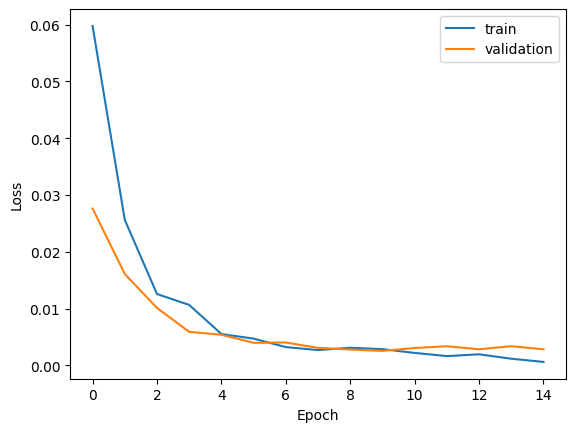

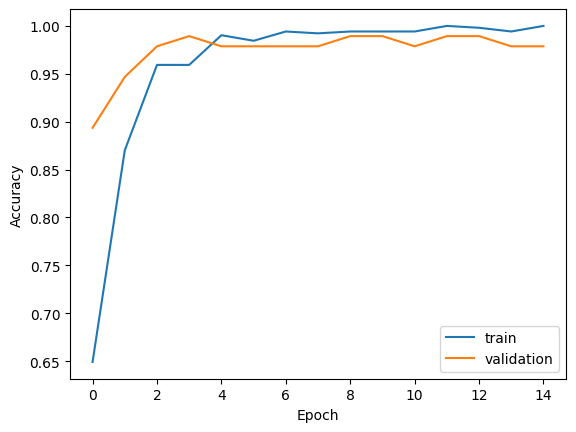

In [ ]:
epoch = 15
file_output_path = model_path + '/vgg16_bn_{:02}.pth'
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_vgg16_bn.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.1)

# Starting model
training(model_vgg16_bn, epoch, file_output_path, optimizer)

### Evaluation

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(cm, y_true, y_pred, classes, plot_label):

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix(' + plot_label + ')')
    plt.savefig(os.path.join(model_path, plot_label + '_Confusion_matrix_vgg16.png'), dpi=300, bbox_inches='tight')
    plt.show()

def plot_classification_report(y_true, y_pred, class_names, plot_label):
    print (classification_report(y_true ,y_pred))
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

    # Convert the report into a DataFrame for easier plotting
    report_df = pd.DataFrame(report).transpose()

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.heatmap(report_df.iloc[:, :3], annot=True, fmt=".2f", cmap="Blues")
    plt.title('Classification Report(' + plot_label + ')')
    plt.xlabel("Metrics")
    plt.ylabel("Classes")
    plt.savefig(os.path.join(model_path, plot_label + '_Classification_Reportx_vgg16.png'), dpi=300, bbox_inches='tight')
    plt.show()

def clf_report(target ,pred , plot_label):
    cm = confusion_matrix(target, pred)
    plot_confusion_matrix(cm,target, pred, class_names, plot_label)
    plot_classification_report(target ,pred, class_names, plot_label)

def detail_eval(model, dataset_loader, plot_label):

  device = check_gpu()
  model = model.to(device)

  model.eval()

  teach_labels_array = []
  pred_labels_array = []

  with torch.no_grad():
    for data, target in dataset_loader:

      input_datas, labels = data.to(device), target.to(device)

      predicted = model(input_datas)
      probabilities = F.softmax(predicted, dim=1)
      predicted_class_index = torch.max(probabilities, dim=1)[1]

      pred_labels = torch.max(predicted, 1)

      teach_labels_array.extend(labels.cpu().numpy())
      pred_labels_array.extend(pred_labels[1].cpu().numpy())

  # Confusion-Matrix & Classification_report
  clf_report(teach_labels_array, pred_labels_array, plot_label)

In [ ]:
import torchvision.models as models
import torch.nn as nn

load_path = model_path + '/vgg16_bn_03.pth'

model_vgg16_bn.load_state_dict(torch.load(load_path))

detail_eval(model_vgg16_bn, test_loader, 'Test Data Evaluation')
detail_eval(model_vgg16_bn, val_loader, 'Validation Data Evaluation')

In [ ]:
'''import os
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import cv2
import matplotlib.pyplot as plt

# Check for GPU
def check_gpu():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load and preprocess the image
def processing_image(image_path):
    # Load the image
    img = Image.open(image_path)

    # Define preprocessing steps
    img_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Apply preprocessing
    img_transform = img_transform(img)  # torch.Size([3, 224, 224])
    inputs = img_transform.unsqueeze(0)  # torch.Size([1, 3, 224, 224])

    return inputs

# Function to predict the model output
def predict_class(model, test_images_path, class_names):
    # Check for GPU
    device = check_gpu()
    model = model.to(device)

    # Switch to evaluation mode
    model.eval()

    with torch.no_grad():
        for img_path in test_images_path:
            dir, fileName = os.path.split(img_path)
            data = processing_image(img_path)
            input_data = data.to(device)

            # Check input shape
            print("Input data shape:", input_data.shape)  # Debugging line

            # Make predictions
            predicted = model(input_data)
            probabilities = F.softmax(predicted, dim=1)

            # After applying softmax to logits
            predicted_class_index = torch.max(probabilities, dim=1)[1]

            # Convert index to class name
            label_name = class_names[predicted_class_index.item()]

            # Display the image
            image = cv2.imread(img_path)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            plt.imshow(image_rgb)
            plt.axis('off')  # Hide axis
            plt.show()

            print(f"{fileName} : {label_name}")

# Set paths and class names
base_path = 'drive/My Drive/'
model_path = '/content/drive/My Drive/PaymentReceipt/model/vgg16'
load_path = model_path + '/vgg16_bn_03.pth'
class_names = ('AYAPay', 'CBPay', 'KPay', 'Other', 'WavePay')

# Load test images
image_folder = os.path.join(base_path, 'PaymentReceipt/dataset/test_Data/KBZ')
test_images_path = glob.glob(image_folder + '/*.*')
if len(test_images_path) > 0:
      # Load the trained model
      model = models.vgg16_bn(pretrained=True)# Load the VGG model with pre-trained weights
      model.classifier[6] = nn.Linear(4096, len(class_names))  # Update the classifier layer
      model.load_state_dict(torch.load(load_path))  # Load your trained model weights

      # Run predictions
      predict_model(model, test_images_path, class_names)
else:
  print("No data")'''